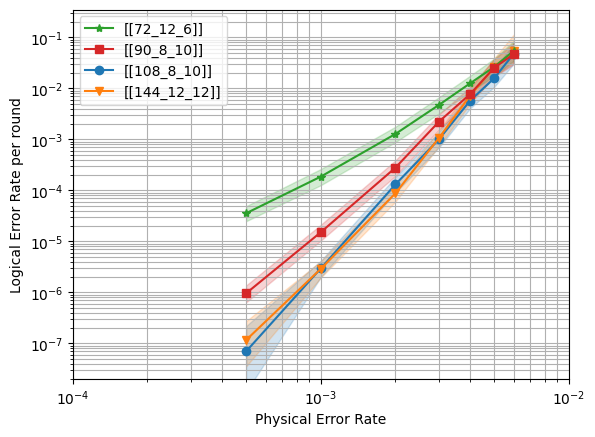

In [13]:
import matplotlib.pyplot as plt
import sinter 
import re


collected_stats = sinter.stats_from_csv_files(f'../collected_stats/collected_stats_tham_modules.csv')


fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
    filter_func=lambda s: s.json_metadata['nkd'] != '[[120_8_8]]'
)

ax.loglog()
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per round")
ax.legend()
ax.grid()
ax.grid(True, which = 'minor')
# fig.set_dpi(120)  # Show it bigger
ax.set_ylim(2e-8, 3.5e-1)
ax.set_xlim(1e-4, 1e-2)


ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()), key=lambda x: tuple(map(int, re.findall(r'\d+', x[1]))))))  # sort legend labels by number of qubits




# ax.figure.savefig(f"../plots/tham_modules_noise.png", dpi = 300, bbox_inches = "tight")
ax.figure.savefig(f"../plots/scrap.png", dpi = 300, bbox_inches = "tight")

In [14]:
for stat in collected_stats:
    print(stat)

    561971,       120,         0,   414.6,bposd,7ec8a317712996cb095c374dd9686d9d3d7db5adfb7279665d0b9dc935e83304,"{""A"":""'300102'"",""B"":""'031020'"",""b"":""Z"",""l"":6,""m"":6,""nkd"":""[[72_12_6]]"",""noise"":""tham_modules"",""p"":0.0005,""r"":6,""seq_gates"":""True""}",
     94242,       105,         0,   107.5,bposd,191d7b165b8ddd71e2b31db3d0ea2297106ee1ea6cbf7f513a9ba953c529b557,"{""A"":""'300102'"",""B"":""'031020'"",""b"":""Z"",""l"":6,""m"":6,""nkd"":""[[72_12_6]]"",""noise"":""tham_modules"",""p"":0.001,""r"":6,""seq_gates"":""True""}",
       753,       104,         0,    8.36,bposd,61c534740e4062303214600ddef552ef41864a7771b7f43ccc89e1427599a0d7,"{""A"":""'300102'"",""B"":""'031020'"",""b"":""Z"",""l"":6,""m"":6,""nkd"":""[[72_12_6]]"",""noise"":""tham_modules"",""p"":0.005,""r"":6,""seq_gates"":""True""}",
       401,       100,         0,    5.57,bposd,616698e7750d6de0652251e21eff1f5b2df416805c9cb8b51b23fe64d4a599c0,"{""A"":""'300102'"",""B"":""'031020'"",""b"":""Z"",